In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import os
import db_connection as db

# load your cleaned flight log
df = db.read_db("flights_cleaned")
print(df.columns)
df.info()
df.head()

Index(['latitude', 'longitude', 'gps_altitude_m', 'distance_m', 'speed_km/s',
       'climb_m', 'climb_m(delta)', 'climb_rate_m/s', 'glide_ratio', 'bearing',
       'delta_bearing', 'elapsed_time', 'delta_time', 'temp', 'pressure',
       'humidity', 'dew_point', 'wind_speed', 'wind_deg'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516903 entries, 0 to 1516902
Data columns (total 19 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   latitude        1516903 non-null  float64
 1   longitude       1516903 non-null  float64
 2   gps_altitude_m  1516903 non-null  int64  
 3   distance_m      1516903 non-null  float64
 4   speed_km/s      1516903 non-null  float64
 5   climb_m         1516903 non-null  float64
 6   climb_m(delta)  1516903 non-null  float64
 7   climb_rate_m/s  1516903 non-null  float64
 8   glide_ratio     1516903 non-null  float64
 9   bearing         1516903 non-null  int64  
 10  delta

,latitude,longitude,gps_altitude_m,distance_m,speed_km/s,climb_m,climb_m(delta),climb_rate_m/s,glide_ratio,bearing,delta_bearing,elapsed_time,delta_time,temp,pressure,humidity,dew_point,wind_speed,wind_deg
0,36.980983,29.314417,2083,7.545830,27.164986,-2.0,0.0,-2.0,3.772915,11,3.0,17.0,1.0,25.62,1008.0,35.0,9.04,0.66,75.0
1,36.981050,29.314450,2082,7.971536,28.697530,-3.0,0.0,-3.0,2.657179,21,10.0,18.0,1.0,25.62,1008.0,35.0,9.04,0.66,75.0
2,36.981150,29.314500,2080,11.957302,43.046289,-2.0,0.0,-2.0,5.978651,21,0.0,19.0,1.0,25.62,1008.0,35.0,9.04,0.66,75.0
3,36.981217,29.314567,2079,9.485179,34.146645,-1.0,-14.0,-1.0,9.485179,38,17.0,20.0,1.0,25.62,1008.0,35.0,9.04,0.66,75.0
4,36.981283,29.314633,2078,9.485176,34.146634,0.0,-14.0,0.0,0.000000,38,0.0,21.0,1.0,25.62,1008.0,35.0,9.04,0.66,75.0


In [36]:
feature_cols = [
    'gps_altitude_m', 'distance_m', 'speed_km/s', #'climb_m', 
    'glide_ratio', 'bearing', 'delta_bearing',
    'temp', 'pressure', 'humidity', 'dew_point',
    'wind_speed', 'wind_deg'
]
X = df[feature_cols].values
y = df['climb_rate_m/s'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)

In [37]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

MAE: 1.5539510571654098
RMSE: 1.9550294763626552


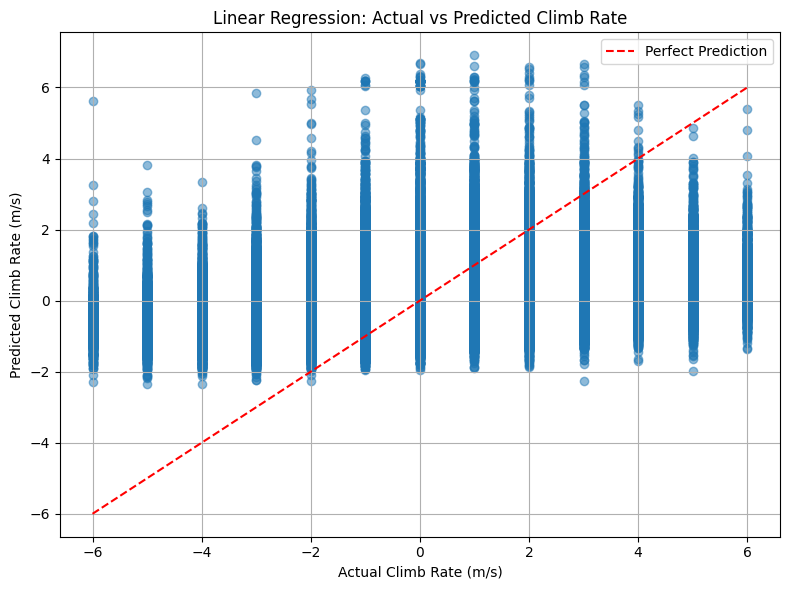

In [38]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Climb Rate (m/s)')
plt.ylabel('Predicted Climb Rate (m/s)')
plt.title('Linear Regression: Actual vs Predicted Climb Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("RF MAE:", mean_absolute_error(y_test, y_pred_rf))
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RF MAE: 1.096344575464544
RMSE: 1.9550294763626552


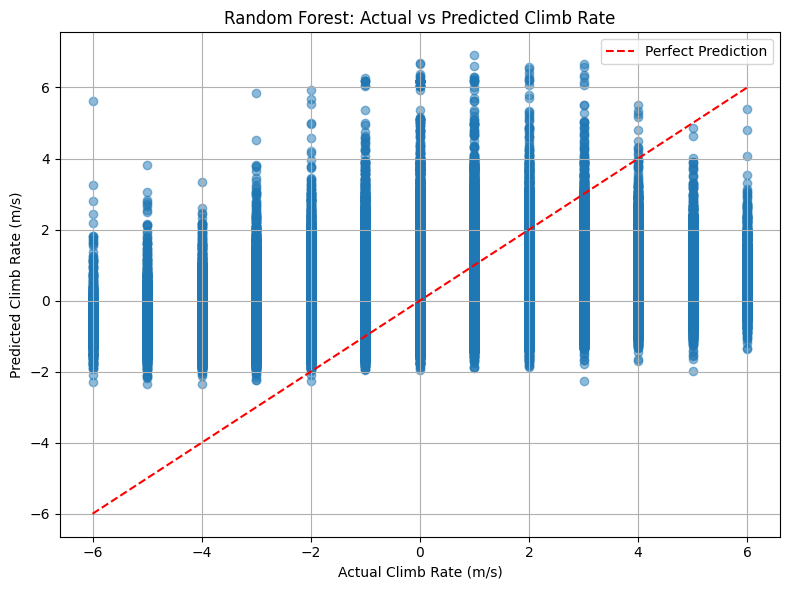

In [40]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Climb Rate (m/s)')
plt.ylabel('Predicted Climb Rate (m/s)')
plt.title('Random Forest: Actual vs Predicted Climb Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
# 5.1 Create sliding windows of length T
def create_sequences(X, y, T=10):
    Xs, ys = [], []
    for i in range(len(X) - T):
        Xs.append(X[i:i+T])
        ys.append(y[i+T])
    return np.array(Xs), np.array(ys)

T = 20  # e.g., 5 previous timesteps
X_seq, y_seq = create_sequences(X_scaled, y, T)

# 5.2 Split
split = int(0.8 * len(X_seq))
X_tr, X_val = X_seq[:split], X_seq[split:]
y_tr, y_val = y_seq[:split], y_seq[split:]

# 5.3 Build LSTM
model = Sequential([
    LSTM(64, input_shape=(T, X_scaled.shape[1]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

es = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[es]
)

# 5.4 Evaluate
mse, mae = model.evaluate(X_val, y_val)
print("LSTM MAE:", mae)
print("LSTM RMSE:", np.sqrt(mse))

e:\Wolf\Belgeler\Projelerim\Paragliding_Flight_Analyses\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
18962/18962 ━━━━━━━━━━━━━━━━━━━━ 144s 7ms/step - loss: 1.9172 - mae: 1.0284 - val_loss: 1.5699 - val_mae: 0.9097
Epoch 2/50
18962/18962 ━━━━━━━━━━━━━━━━━━━━ 141s 7ms/step - loss: 1.2809 - mae: 0.8381 - val_loss: 1.5546 - val_mae: 0.9011
Epoch 3/50
18962/18962 ━━━━━━━━━━━━━━━━━━━━ 142s 7ms/step - loss: 1.2197 - mae: 0.8195 - val_loss: 1.5408 - val_mae: 0.8958
Epoch 4/50
18962/18962 ━━━━━━━━━━━━━━━━━━━━ 147s 8ms/step - loss: 1.1851 - mae: 0.8104 - val_loss: 1.5485 - val_mae: 0.8919
Epoch 5/50
18962/18962 ━━━━━━━━━━━━━━━━━━━━ 147s 8ms/step - loss: 1.1609 - mae: 0.8034 - val_loss: 1.5682 - val_mae: 0.9001
Epoch 6/50
18962/18962 ━━━━━━━━━━━━━━━━━━━━ 145s 8ms/step - loss: 1.1420 - mae: 0.7988 - val_loss: 1.5747 - val_mae: 0.8994
Epoch 7/50
18962/18962 ━━━━━━━━━━━━━━━━━━━━ 144s 8ms/step - loss: 1.1263 - mae: 0.7941 - val_loss: 1.5830 - val_mae: 0.9009
Epoch 8/50
18962/18962 ━━━━━━━━━━━━━━━━━━━━ 146s 8ms/step - loss: 1.1138 - mae: 0.7906 - val_loss: 1.6016 - val_mae: 0.9035
9481/948

In [42]:
# 1. Generate predictions
y_pred = model.predict(X_val).flatten()
actual = y_val

# 2. Compute residuals
residuals = actual - y_pred


9481/9481 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


In [51]:
df_predict = pd.DataFrame({'Actual': actual, 'Predicted': y_pred, 'Residuals': residuals})
df_predict.head()

,Actual,Predicted,Residuals
0,2.0,3.136993,-1.136993
1,1.0,1.532806,-0.532806
2,1.0,0.569996,0.430004
3,1.0,0.743928,0.256072
4,1.0,1.152034,-0.152034


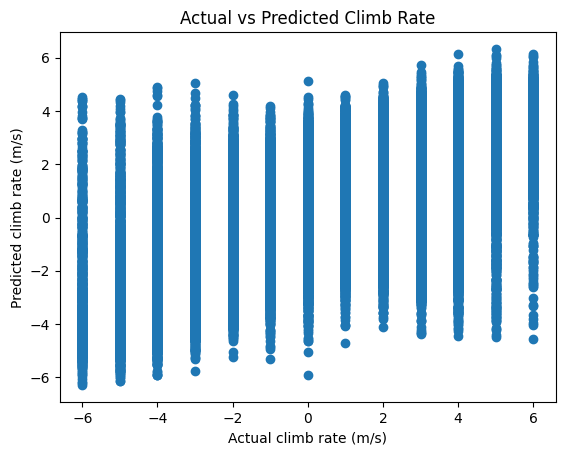

In [44]:

# 3. Scatter: actual vs. predicted
plt.figure()
plt.scatter(actual, y_pred)
plt.xlabel("Actual climb rate (m/s)")
plt.ylabel("Predicted climb rate (m/s)")
plt.title("Actual vs Predicted Climb Rate")
plt.show()


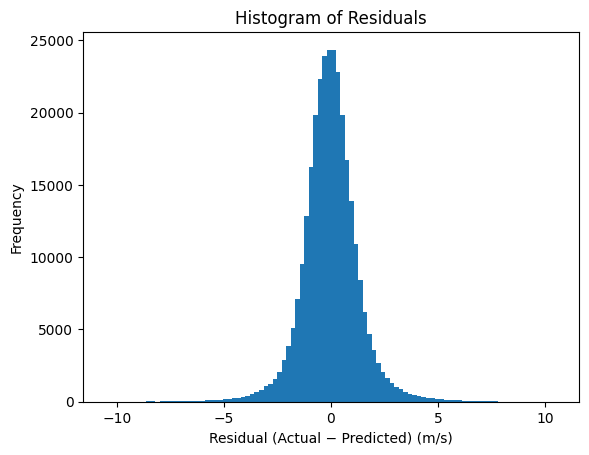

In [45]:
# 4. Histogram of residuals
plt.figure()
plt.hist(residuals, bins=100)
plt.xlabel("Residual (Actual − Predicted) (m/s)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

In [46]:
# residuals = actual - y_pred from before
res_mean = np.mean(residuals)
res_std  = np.std(residuals)
print(f"Mean residual: {res_mean:.3f} m/s")
print(f"Residual STD : {res_std:.3f} m/s")

for thr in (0.5, 1.0, 2.0):
    pct = (np.abs(residuals) <= thr).mean() * 100
    print(f"% of errors within ±{thr:.1f} m/s: {pct:.1f}%")

Mean residual: -0.023 m/s
Residual STD : 1.316 m/s
% of errors within ±0.5 m/s: 36.9%
% of errors within ±1.0 m/s: 65.1%
% of errors within ±2.0 m/s: 90.0%


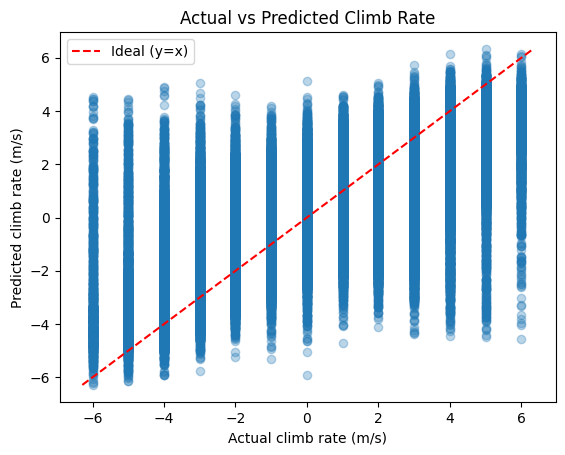

In [47]:
mn = min(actual.min(), y_pred.min())
mx = max(actual.max(), y_pred.max())

plt.figure()
plt.scatter(actual, y_pred, alpha=0.3)
plt.plot([mn, mx], [mn, mx], 'r--', label='Ideal (y=x)')
plt.xlabel("Actual climb rate (m/s)")
plt.ylabel("Predicted climb rate (m/s)")
plt.title("Actual vs Predicted Climb Rate")
plt.legend()
plt.show()

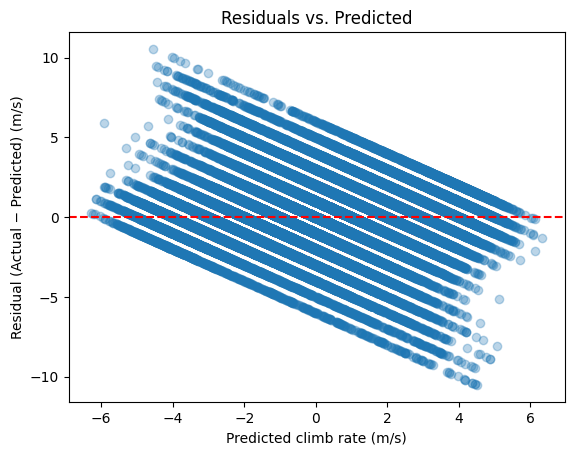

In [48]:
plt.figure()
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted climb rate (m/s)")
plt.ylabel("Residual (Actual − Predicted) (m/s)")
plt.title("Residuals vs. Predicted")
plt.show()

In [53]:
residuals = actual - y_pred  # from before

print("Mean residual:", np.mean(residuals))
print("Residual std:",   np.std(residuals))

for thr in (0.5, 1.0, 2.0):
    pct = (np.abs(residuals) <= thr).mean() * 100
    print(f"% of errors within ±{thr:.1f} m/s:", f"{pct:.1f}%")

Mean residual: -0.022698005638369188
Residual std: 1.3157112453178155
% of errors within ±0.5 m/s: 36.9%
% of errors within ±1.0 m/s: 65.1%
% of errors within ±2.0 m/s: 90.0%


In [ ]:
# model.save("lstm_model.h5")
save_path = os.path.join('models', 'lstm_model.keras')
model.save(save_path)